## Challenge

As a social network platform, one of our major concerns is user churn. The ability to identify potential user
churn and proactively respond to retain those users is a valuable asset. 

Your challenge is two-fold:
- Design a solution to identify users at risk of churning. This solution should include your approach to data
analysis, choice of model(s), feature selection, and strategies for user retention.
- Implement a proof of concept of your solution design. This includes data preprocessing, a basic prediction
model for user churn, and evaluation of the model's performance.

In [1]:
!python --version

Python 3.11.4


In [8]:
import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix, log_loss, precision_recall_curve

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

from IPython import display

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

### Dataset
You will be provided with a synthetic dataset that includes user activity and churn status. Please note that we
define a user "churned" if they did not visit within the **last two months**. You are expected to use this dataset
for your analysis and model.

In [3]:
df = pd.read_csv("./data/...csv")

In [4]:
df.head()

,USER_ID,REGISTRATION_AT,TOTAL_VISIT_COUNT,LAST_VISIT_AT,TOTAL_POST_COUNT,LAST_POST_AT,TOTAL_LIKES_RECEIVED,LAST_LIKE_RECEIVED_AT,TOTAL_COMMENTS_RECEIVED,LAST_COMMENT_RECEIVED_AT,TOTAL_LIKES_GIVEN,LAST_LIKE_GIVEN_AT,TOTAL_COMMENTS_WRITTEN,LAST_COMMENT_WRITTEN_AT,CHURNED
0,1,2022-03-01T00:57:42.892766Z,248,2023-07-19,1.0,2022-07-04T17:05:49.158857Z,0.0,NaN,2.0,2022-07-04T19:09:10.045534Z,8.0,2023-06-23T22:51:45.039526Z,1.0,2022-07-04T19:09:10.045534Z,False
1,2,2022-03-01T03:29:48.358945Z,13,2023-07-15,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2023-07-15T12:09:54.895868Z,2.0,2022-09-25T08:37:19.145993Z,False
2,3,2022-03-01T04:59:44.533405Z,99,2023-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,4,2022-03-01T05:32:09.776362Z,10,2023-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,5,2022-03-01T05:45:20.568181Z,13,2023-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [5]:
df.columns

Index(['USER_ID', 'REGISTRATION_AT', 'TOTAL_VISIT_COUNT', 'LAST_VISIT_AT',
       'TOTAL_POST_COUNT', 'LAST_POST_AT', 'TOTAL_LIKES_RECEIVED',
       'LAST_LIKE_RECEIVED_AT', 'TOTAL_COMMENTS_RECEIVED',
       'LAST_COMMENT_RECEIVED_AT', 'TOTAL_LIKES_GIVEN', 'LAST_LIKE_GIVEN_AT',
       'TOTAL_COMMENTS_WRITTEN', 'LAST_COMMENT_WRITTEN_AT', 'CHURNED'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   USER_ID                   50000 non-null  int64  
 1   REGISTRATION_AT           50000 non-null  object 
 2   TOTAL_VISIT_COUNT         50000 non-null  int64  
 3   LAST_VISIT_AT             50000 non-null  object 
 4   TOTAL_POST_COUNT          11922 non-null  float64
 5   LAST_POST_AT              11922 non-null  object 
 6   TOTAL_LIKES_RECEIVED      11922 non-null  float64
 7   LAST_LIKE_RECEIVED_AT     6393 non-null   object 
 8   TOTAL_COMMENTS_RECEIVED   11922 non-null  float64
 9   LAST_COMMENT_RECEIVED_AT  8144 non-null   object 
 10  TOTAL_LIKES_GIVEN         13214 non-null  float64
 11  LAST_LIKE_GIVEN_AT        13214 non-null  object 
 12  TOTAL_COMMENTS_WRITTEN    11661 non-null  float64
 13  LAST_COMMENT_WRITTEN_AT   11661 non-null  object 
 14  CHURNE

<Axes: >

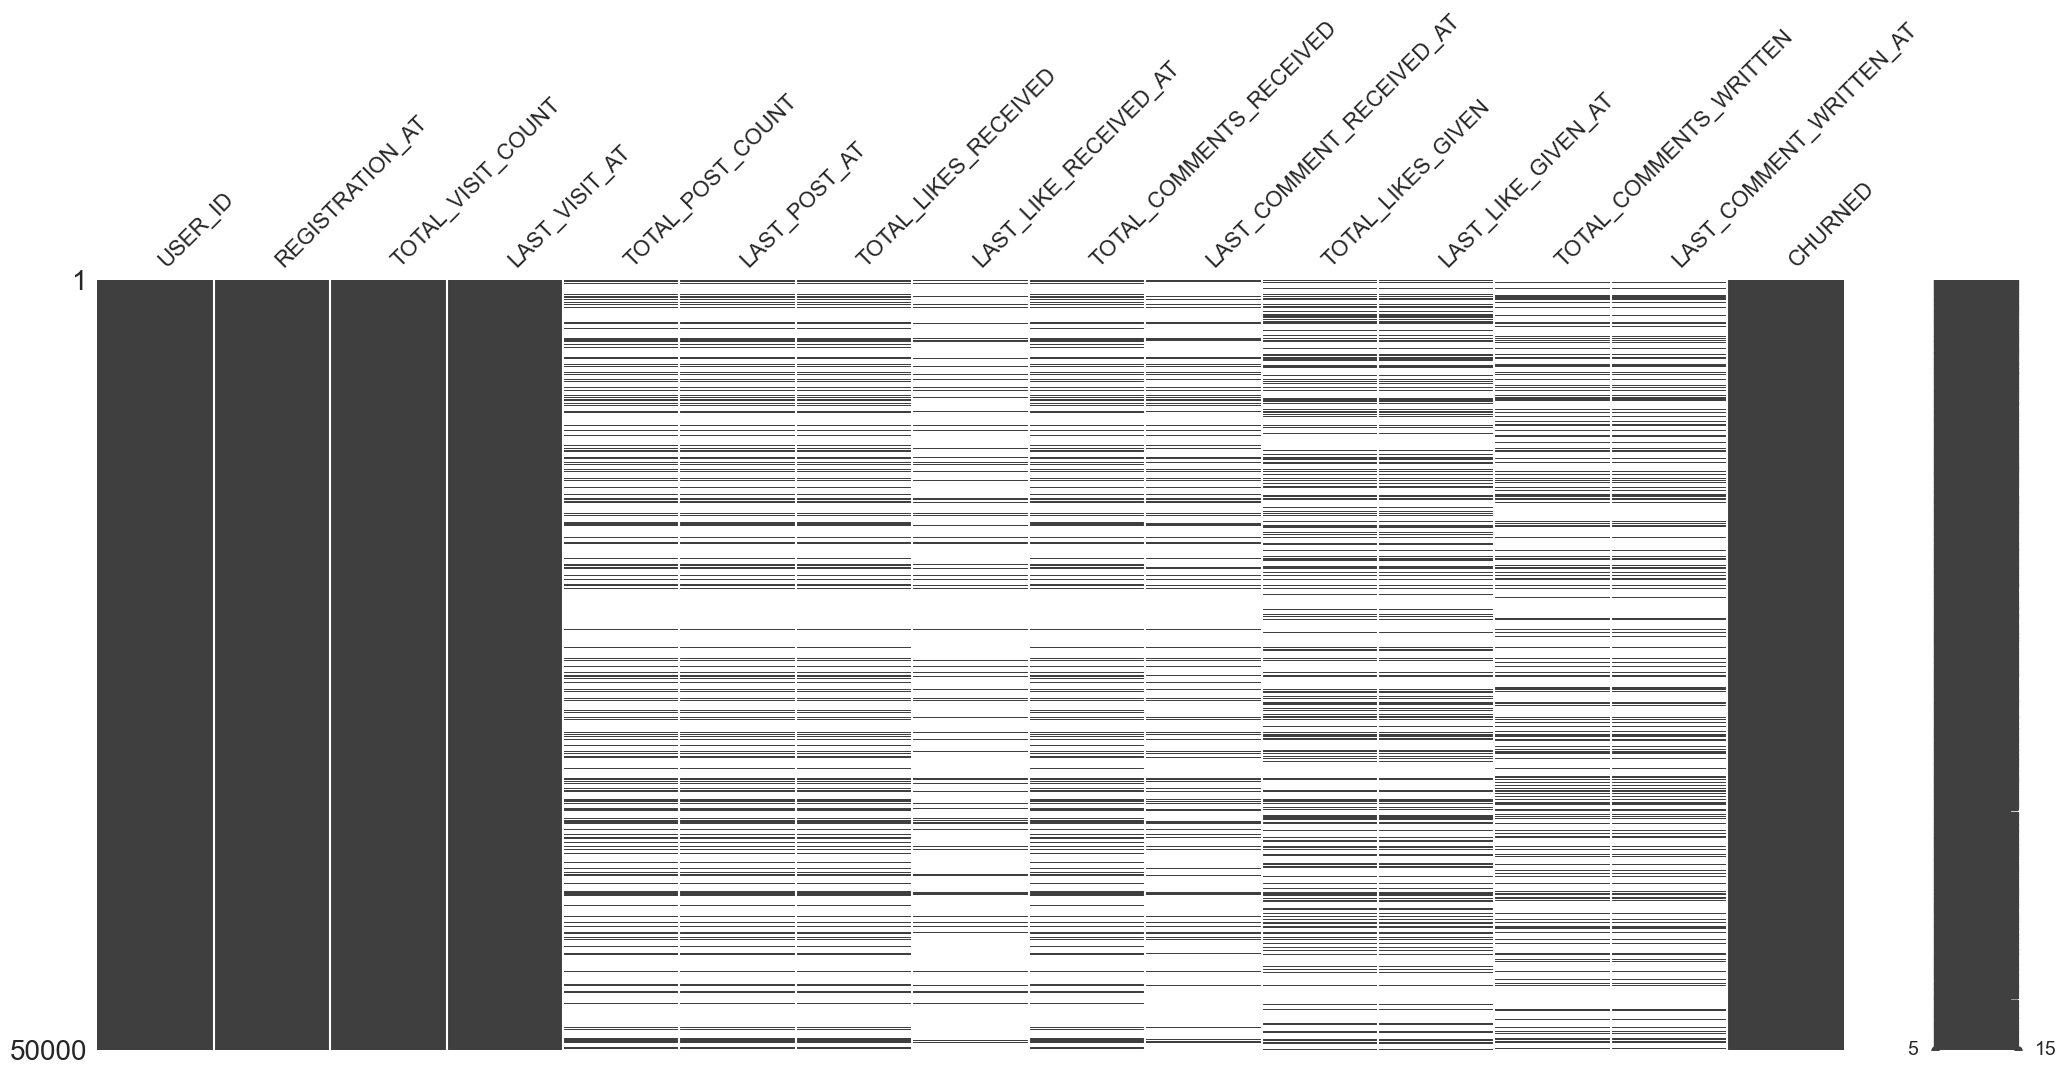

In [7]:
msno.matrix(df)

### Feature Engineering

In [9]:
# Convert dates to datetime format
date_cols = ['REGISTRATION_AT', 'LAST_VISIT_AT', 'LAST_POST_AT', 
             'LAST_LIKE_RECEIVED_AT', 'LAST_COMMENT_RECEIVED_AT', 
             'LAST_LIKE_GIVEN_AT', 'LAST_COMMENT_WRITTEN_AT']

for col in date_cols:
    df[col] = pd.to_datetime(df[col]).dt.tz_localize(None)

In [10]:
df.head()

,USER_ID,REGISTRATION_AT,TOTAL_VISIT_COUNT,LAST_VISIT_AT,TOTAL_POST_COUNT,LAST_POST_AT,TOTAL_LIKES_RECEIVED,LAST_LIKE_RECEIVED_AT,TOTAL_COMMENTS_RECEIVED,LAST_COMMENT_RECEIVED_AT,TOTAL_LIKES_GIVEN,LAST_LIKE_GIVEN_AT,TOTAL_COMMENTS_WRITTEN,LAST_COMMENT_WRITTEN_AT,CHURNED
0,1,2022-03-01 00:57:42.892766,248,2023-07-19,1.0,2022-07-04 17:05:49.158857,0.0,NaT,2.0,2022-07-04 19:09:10.045534,8.0,2023-06-23 22:51:45.039526,1.0,2022-07-04 19:09:10.045534,False
1,2,2022-03-01 03:29:48.358945,13,2023-07-15,NaN,NaT,NaN,NaT,NaN,NaT,8.0,2023-07-15 12:09:54.895868,2.0,2022-09-25 08:37:19.145993,False
2,3,2022-03-01 04:59:44.533405,99,2023-04-27,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,True
3,4,2022-03-01 05:32:09.776362,10,2023-06-12,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,False
4,5,2022-03-01 05:45:20.568181,13,2023-03-07,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,True


In [11]:
# Get the list of non-date columns
non_date_cols = [col for col in df.columns if col not in date_cols]

# Fill missing values in non-date columns
for col in non_date_cols:
    df[col].fillna(0, inplace=True)

In [12]:
# Fill missing values (in this case, we'll fill with zeros, but this can be adjusted as necessary)
df.drop(date_cols, axis=1).fillna(0, inplace=True)

In [13]:
current_date = datetime.datetime.now().replace(tzinfo=None)

In [14]:
df.columns

Index(['USER_ID', 'REGISTRATION_AT', 'TOTAL_VISIT_COUNT', 'LAST_VISIT_AT',
       'TOTAL_POST_COUNT', 'LAST_POST_AT', 'TOTAL_LIKES_RECEIVED',
       'LAST_LIKE_RECEIVED_AT', 'TOTAL_COMMENTS_RECEIVED',
       'LAST_COMMENT_RECEIVED_AT', 'TOTAL_LIKES_GIVEN', 'LAST_LIKE_GIVEN_AT',
       'TOTAL_COMMENTS_WRITTEN', 'LAST_COMMENT_WRITTEN_AT', 'CHURNED'],
      dtype='object')

In [15]:
df['USER_AGE'] = (current_date - df['REGISTRATION_AT']).dt.days
df['DAYS_SINCE_LAST_VISIT'] = (current_date - df['LAST_VISIT_AT']).dt.days

In [16]:
df['DAYS_SINCE_LAST_POST'] = (
    df['LAST_POST_AT'].apply(
        lambda x: (current_date - x).days if isinstance(x, pd.Timestamp) else np.nan
    )
)

df['DAYS_SINCE_LAST_LIKE_RECEIVED'] = (
    df['LAST_LIKE_RECEIVED_AT'].apply(
        lambda x: (current_date - x).days if isinstance(x, pd.Timestamp) else np.nan
    )
)

df['DAYS_SINCE_LAST_LIKE_GIVEN'] = (
    df['LAST_LIKE_GIVEN_AT'].apply(
        lambda x: (current_date - x).days if isinstance(x, pd.Timestamp) else np.nan
    )
)

df['DAYS_SINCE_LAST_COMMENT_RECEIVED'] = (
    df['LAST_COMMENT_RECEIVED_AT'].apply(
        lambda x: (current_date - x).days if isinstance(x, pd.Timestamp) else np.nan
    )
)

df['DAYS_SINCE_LAST_COMMENT_WRITTEN'] = (
    df['LAST_COMMENT_WRITTEN_AT'].apply(
        lambda x: (current_date - x).days if isinstance(x, pd.Timestamp) else np.nan
    )
)

In [17]:
df.head()

,USER_ID,REGISTRATION_AT,TOTAL_VISIT_COUNT,LAST_VISIT_AT,TOTAL_POST_COUNT,LAST_POST_AT,TOTAL_LIKES_RECEIVED,LAST_LIKE_RECEIVED_AT,TOTAL_COMMENTS_RECEIVED,LAST_COMMENT_RECEIVED_AT,...,TOTAL_COMMENTS_WRITTEN,LAST_COMMENT_WRITTEN_AT,CHURNED,USER_AGE,DAYS_SINCE_LAST_VISIT,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_COMMENT_WRITTEN
0,1,2022-03-01 00:57:42.892766,248,2023-07-19,1.0,2022-07-04 17:05:49.158857,0.0,NaT,2.0,2022-07-04 19:09:10.045534,...,1.0,2022-07-04 19:09:10.045534,False,524,19,398.0,NaN,44.0,398.0,398.0
1,2,2022-03-01 03:29:48.358945,13,2023-07-15,0.0,NaT,0.0,NaT,0.0,NaT,...,2.0,2022-09-25 08:37:19.145993,False,524,23,NaN,NaN,22.0,NaN,316.0
2,3,2022-03-01 04:59:44.533405,99,2023-04-27,0.0,NaT,0.0,NaT,0.0,NaT,...,0.0,NaT,True,524,102,NaN,NaN,NaN,NaN,NaN
3,4,2022-03-01 05:32:09.776362,10,2023-06-12,0.0,NaT,0.0,NaT,0.0,NaT,...,0.0,NaT,False,524,56,NaN,NaN,NaN,NaN,NaN
4,5,2022-03-01 05:45:20.568181,13,2023-03-07,0.0,NaT,0.0,NaT,0.0,NaT,...,0.0,NaT,True,524,153,NaN,NaN,NaN,NaN,NaN


In [18]:
df['LIKES_TO_POSTS'] = df['TOTAL_LIKES_RECEIVED'] / df['TOTAL_POST_COUNT']
df['COMMENTS_TO_POSTS'] = df['TOTAL_COMMENTS_RECEIVED'] / df['TOTAL_POST_COUNT']

In [19]:
# Replace infinite values generated from division by zero
df.replace([np.inf, -np.inf], 0, inplace=True)

In [20]:
df.head()

,USER_ID,REGISTRATION_AT,TOTAL_VISIT_COUNT,LAST_VISIT_AT,TOTAL_POST_COUNT,LAST_POST_AT,TOTAL_LIKES_RECEIVED,LAST_LIKE_RECEIVED_AT,TOTAL_COMMENTS_RECEIVED,LAST_COMMENT_RECEIVED_AT,...,CHURNED,USER_AGE,DAYS_SINCE_LAST_VISIT,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_COMMENT_WRITTEN,LIKES_TO_POSTS,COMMENTS_TO_POSTS
0,1,2022-03-01 00:57:42.892766,248,2023-07-19,1.0,2022-07-04 17:05:49.158857,0.0,NaT,2.0,2022-07-04 19:09:10.045534,...,False,524,19,398.0,NaN,44.0,398.0,398.0,0.0,2.0
1,2,2022-03-01 03:29:48.358945,13,2023-07-15,0.0,NaT,0.0,NaT,0.0,NaT,...,False,524,23,NaN,NaN,22.0,NaN,316.0,NaN,NaN
2,3,2022-03-01 04:59:44.533405,99,2023-04-27,0.0,NaT,0.0,NaT,0.0,NaT,...,True,524,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2022-03-01 05:32:09.776362,10,2023-06-12,0.0,NaT,0.0,NaT,0.0,NaT,...,False,524,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2022-03-01 05:45:20.568181,13,2023-03-07,0.0,NaT,0.0,NaT,0.0,NaT,...,True,524,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Examine Evaluation Metrics

Churn prediction is typically addressed as a binary classification problem where a customer that has churned is identified as the positive class, and a customer that has not churned is identified as the negative class. In a well-run business, the number of churn events taking place in a given time period should be fairly low, creating an imbalance between the occurrence of negative and positive class events. Another way of saying this is that the positive class is the minority class and the negative class is the majority class.

To understand this, let's examine the imbalance between negative and positive churn events in our training and testing datasets:

In [21]:
df['CHURNED'].value_counts()

False    25000
True     25000
Name: CHURNED, dtype: int64

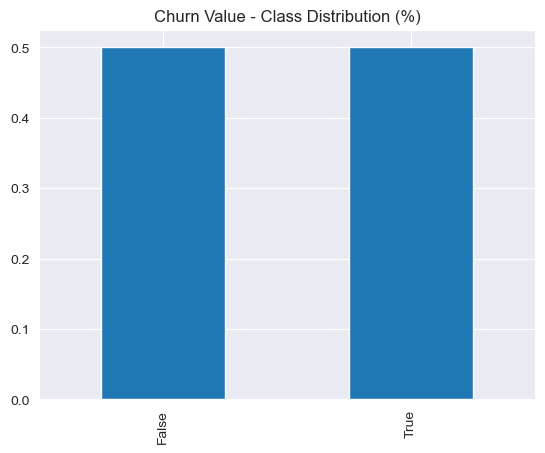

In [22]:
df['CHURNED'].value_counts(normalize=True).plot(kind='bar', title='Churn Value - Class Distribution (%)')
plt.show()

Very balanced dataset  - 50/50 ?

<Axes: >

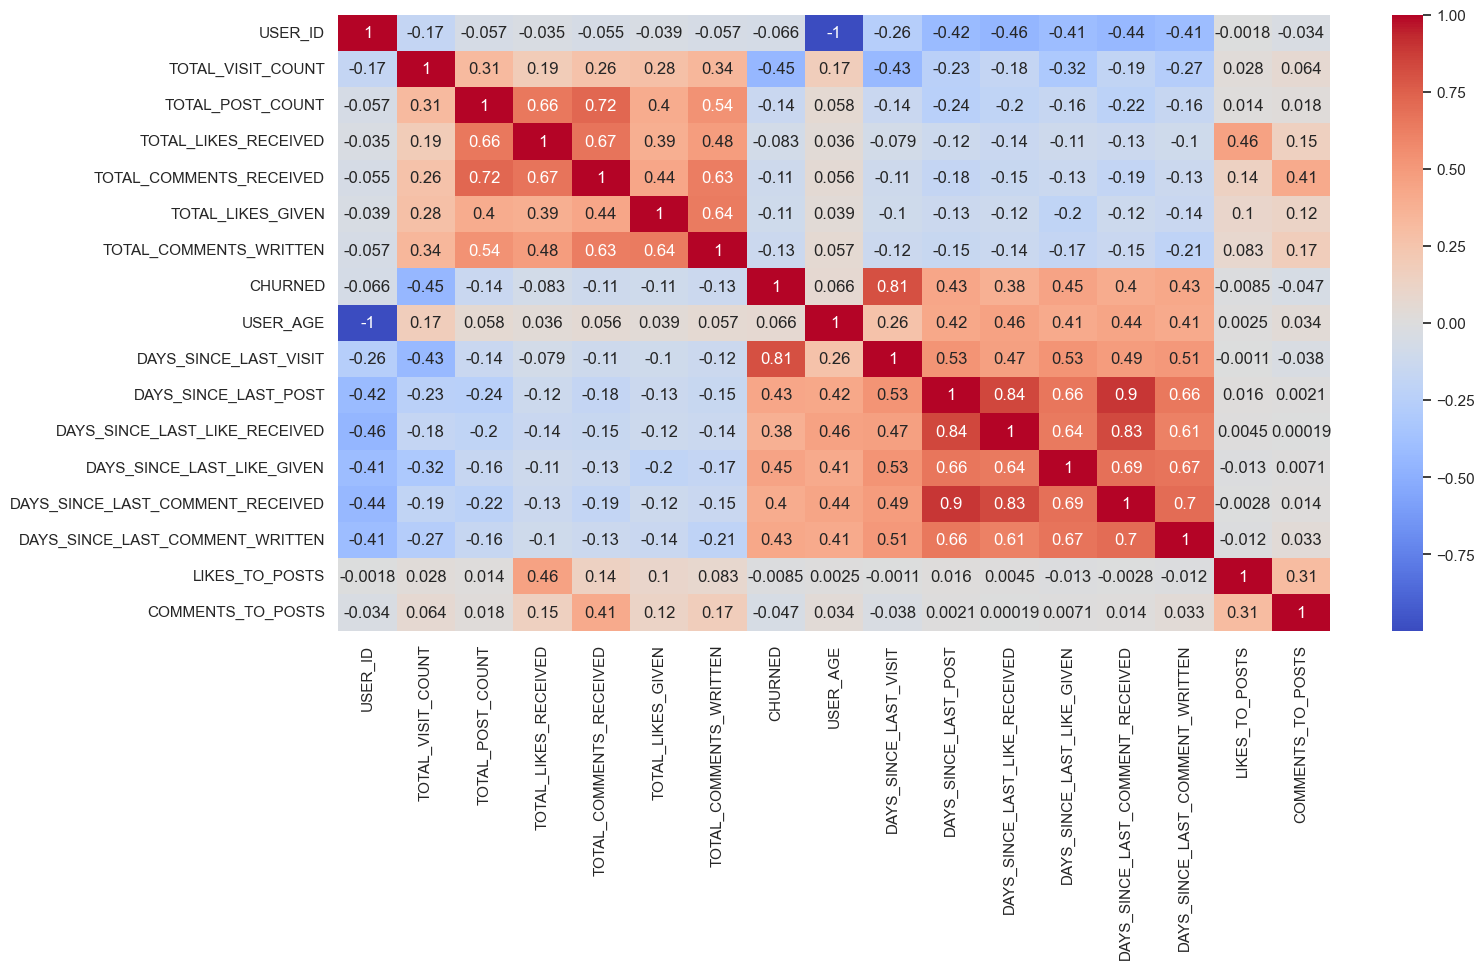

In [23]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [24]:
df.columns

Index(['USER_ID', 'REGISTRATION_AT', 'TOTAL_VISIT_COUNT', 'LAST_VISIT_AT',
       'TOTAL_POST_COUNT', 'LAST_POST_AT', 'TOTAL_LIKES_RECEIVED',
       'LAST_LIKE_RECEIVED_AT', 'TOTAL_COMMENTS_RECEIVED',
       'LAST_COMMENT_RECEIVED_AT', 'TOTAL_LIKES_GIVEN', 'LAST_LIKE_GIVEN_AT',
       'TOTAL_COMMENTS_WRITTEN', 'LAST_COMMENT_WRITTEN_AT', 'CHURNED',
       'USER_AGE', 'DAYS_SINCE_LAST_VISIT', 'DAYS_SINCE_LAST_POST',
       'DAYS_SINCE_LAST_LIKE_RECEIVED', 'DAYS_SINCE_LAST_LIKE_GIVEN',
       'DAYS_SINCE_LAST_COMMENT_RECEIVED', 'DAYS_SINCE_LAST_COMMENT_WRITTEN',
       'LIKES_TO_POSTS', 'COMMENTS_TO_POSTS'],
      dtype='object')

Text(0.5, 1.0, 'Total Comment Written Count vs Churn')

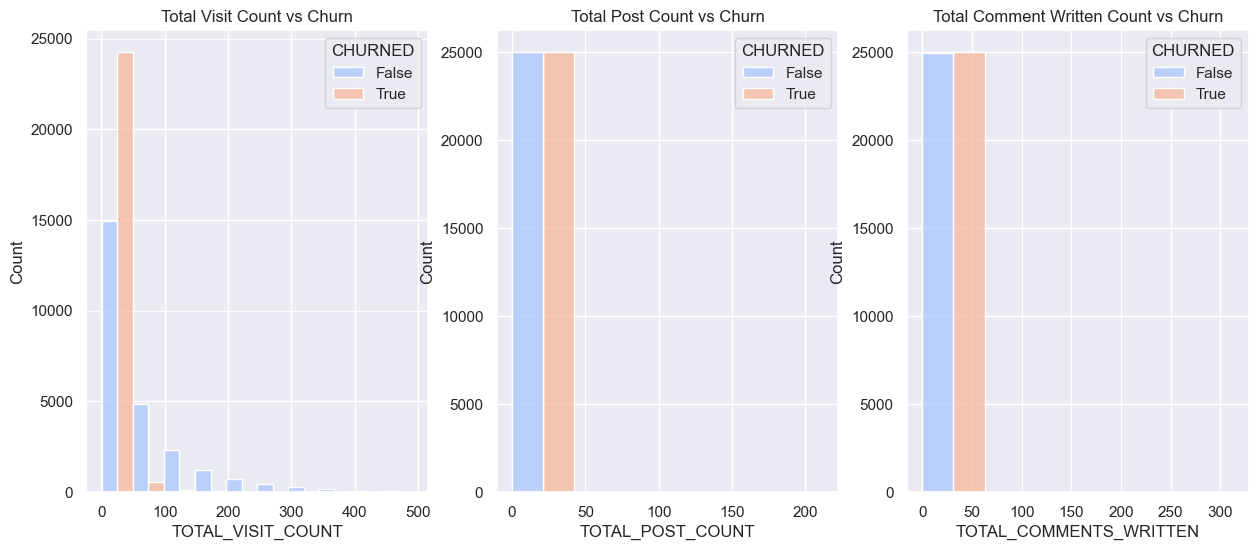

In [25]:
# Numerical variables
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

## Are churned customers likely to visit less?
plt.subplot(1,3,1)
sns.histplot(df, x='TOTAL_VISIT_COUNT', hue='CHURNED', palette='coolwarm', multiple='dodge', bins=10)
plt.title('Total Visit Count vs Churn')

## Are churned customers likely to post less?
plt.subplot(1,3,2)
sns.histplot(df, x='TOTAL_POST_COUNT', hue='CHURNED', palette='coolwarm', multiple='dodge', bins=5)
plt.title('Total Post Count vs Churn')

## Are churned customers likely to comment less?
plt.subplot(1,3,3)
sns.histplot(df, x='TOTAL_COMMENTS_WRITTEN', hue='CHURNED', palette='coolwarm', multiple='dodge', bins=5)
plt.title('Total Comment Written Count vs Churn')

Text(0.5, 1.0, 'User Age vs Churn')

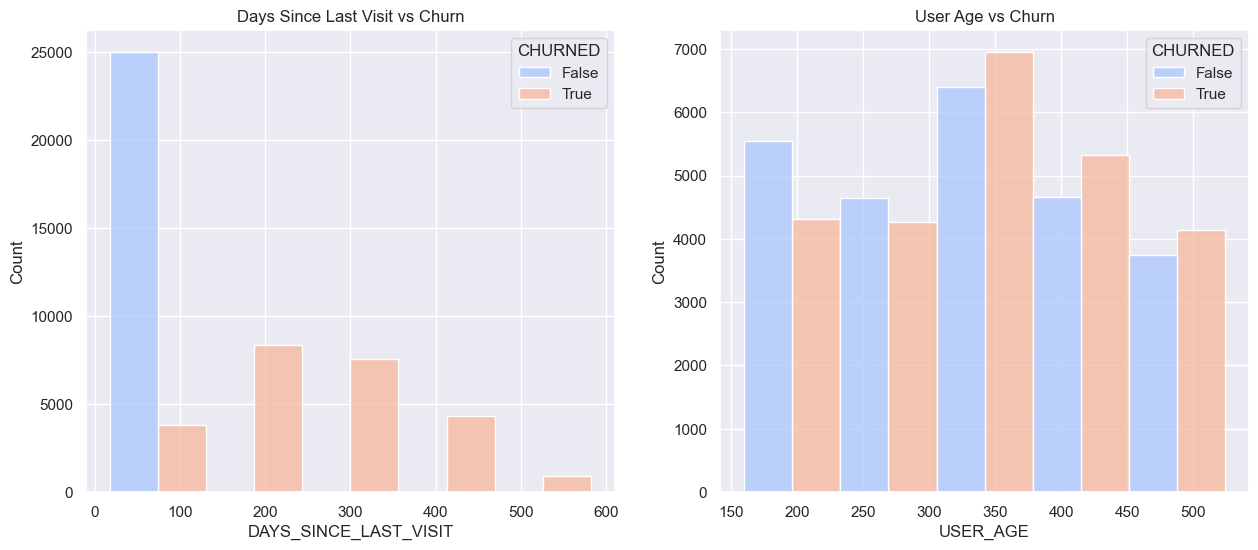

In [26]:
# Numerical variables
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

## Are churned customers likely to have a higher days since last visit?
plt.subplot(1,2,1)
sns.histplot(df, x='DAYS_SINCE_LAST_VISIT', hue='CHURNED', palette='coolwarm', multiple='dodge', bins=5)
plt.title('Days Since Last Visit vs Churn')

## Are churned customers likely to have a lower age?
plt.subplot(1,2,2)
sns.histplot(df, x='USER_AGE', hue='CHURNED', palette='coolwarm', multiple='dodge', bins=5)
plt.title('User Age vs Churn')

Text(0.5, 1.0, 'User Age vs Churn')

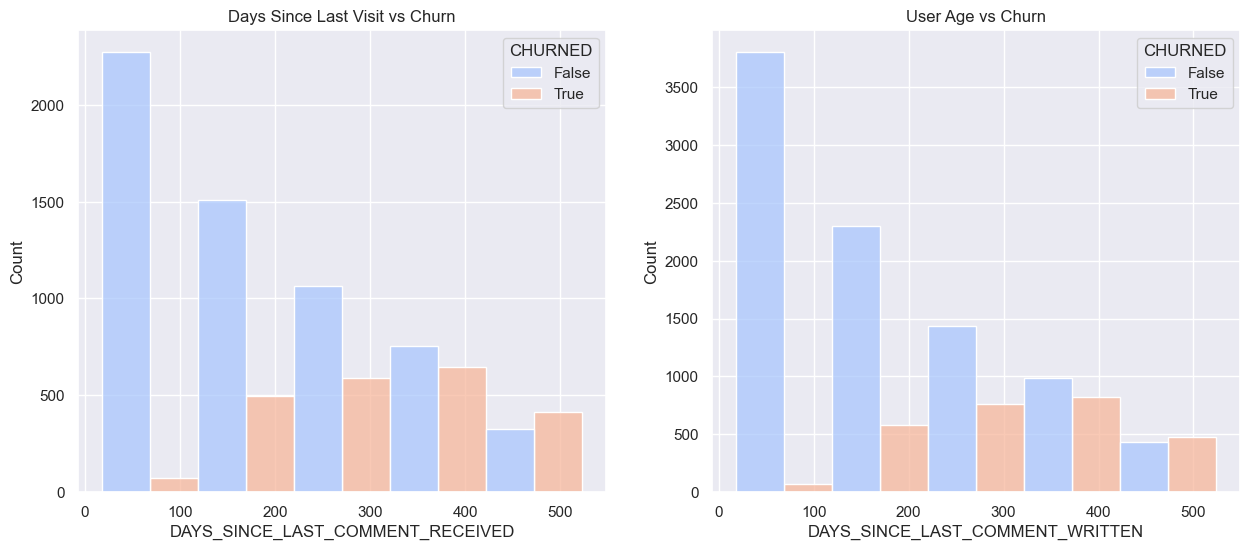

In [27]:
# Numerical variables
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

## Are churned customers likely to have a higher days since last visit?
plt.subplot(1,2,1)
sns.histplot(df, x='DAYS_SINCE_LAST_COMMENT_RECEIVED', hue='CHURNED', palette='coolwarm', multiple='dodge', bins=5)
plt.title('Days Since Last Visit vs Churn')

## Are churned customers likely to have a lower age?
plt.subplot(1,2,2)
sns.histplot(df, x='DAYS_SINCE_LAST_COMMENT_WRITTEN', hue='CHURNED', palette='coolwarm', multiple='dodge', bins=5)
plt.title('User Age vs Churn')

# Model Building/Validation/Tuning

We use gradient-boosted tree models from the `lightgbm` library 

In [28]:
x = df.drop(columns=["CHURNED", "DAYS_SINCE_LAST_VISIT", "USER_ID"] + date_cols)
y = df[["CHURNED"]]

In [29]:
x.head()

,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,USER_AGE,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_COMMENT_WRITTEN,LIKES_TO_POSTS,COMMENTS_TO_POSTS
0,248,1.0,0.0,2.0,8.0,1.0,524,398.0,NaN,44.0,398.0,398.0,0.0,2.0
1,13,0.0,0.0,0.0,8.0,2.0,524,NaN,NaN,22.0,NaN,316.0,NaN,NaN
2,99,0.0,0.0,0.0,0.0,0.0,524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,0.0,0.0,0.0,0.0,0.0,524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,0.0,0.0,0.0,0.0,0.0,524,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [31]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [32]:
y_pred=clf.predict(X_test)
y_pred_proba=clf.predict_proba(X_test)[:,1]

In [33]:
y_test_plot = y_test.reset_index()
churn_idx = y_test_plot[y_test_plot["CHURNED"] == 1].index
no_churn_idx = y_test_plot[y_test_plot["CHURNED"] == 0].index

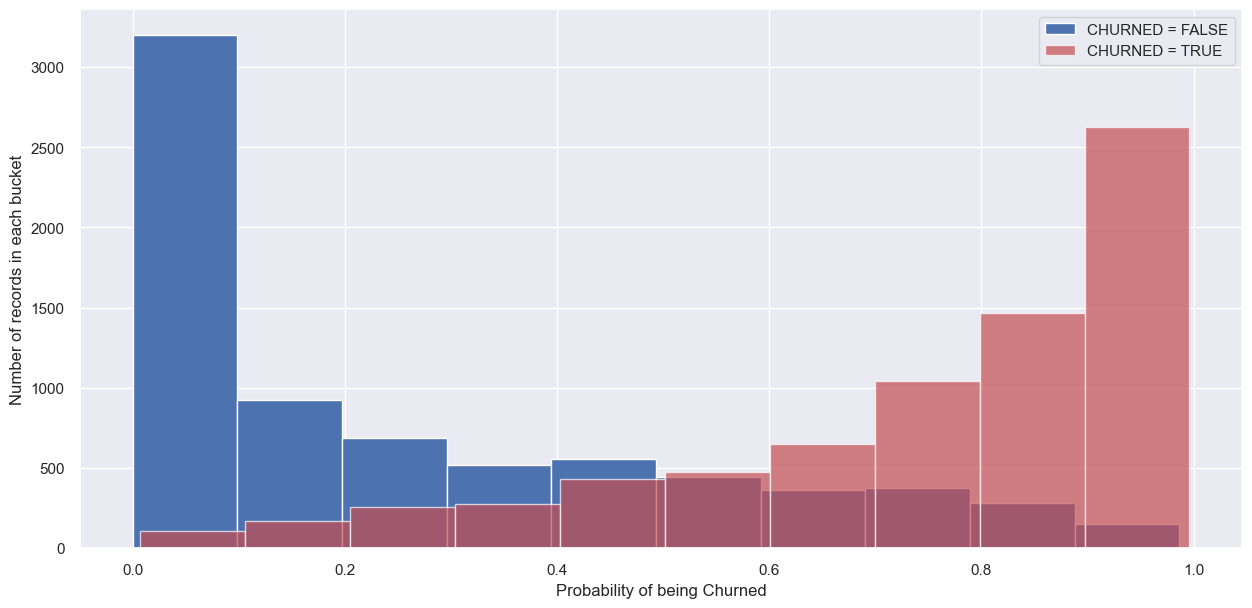

In [34]:
plt.figure(figsize=(15,7))
plt.hist(y_pred_proba[no_churn_idx], bins=10, label='CHURNED = FALSE')
plt.hist(y_pred_proba[churn_idx], bins=10, label='CHURNED = TRUE', alpha=0.7, color='r')
plt.xlabel('Probability of being Churned')
plt.ylabel('Number of records in each bucket')
plt.tick_params(axis='both', pad=5)
plt.legend()
plt.show()

In [35]:
# view accuracy
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8126


##### Check for Overfitting

In [36]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.8351
Test set score: 0.8126


We were able to predict churn for test data - in practice this could be for example new customers - with an accuracy of almost **81%**


True Positives(TP) =  5932
True Negatives(TN) =  6257
False Positives(FP) =  1572
False Negatives(FN) =  1239




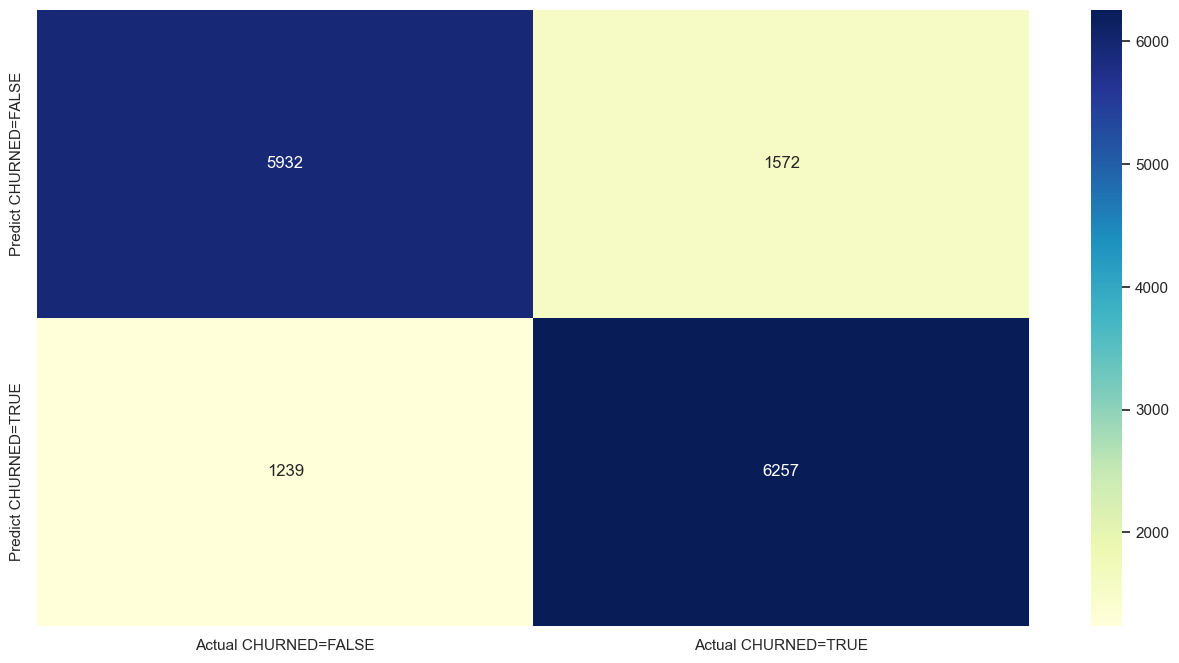

In [37]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual CHURNED=FALSE', 'Actual CHURNED=TRUE'], 
                                    index=['Predict CHURNED=FALSE', 'Predict CHURNED=TRUE'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

print('\nTrue Positives(TP) = ', cm[0,0])
print('True Negatives(TN) = ', cm[1,1])
print('False Positives(FP) = ', cm[0,1])
print('False Negatives(FN) = ', cm[1,0])
print('\n')

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.79      0.81      7504
        True       0.80      0.83      0.82      7496

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000



In [39]:
y_scores = clf.predict_proba(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_scores[:, 1])

In [40]:
optimal_proba_cutoff = sorted(list(zip(np.abs(precision - recall), threshold)), key=lambda i: i[0], reverse=False)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_scores[:, -1]]

In [41]:
optimal_proba_cutoff

0.5389666557113116

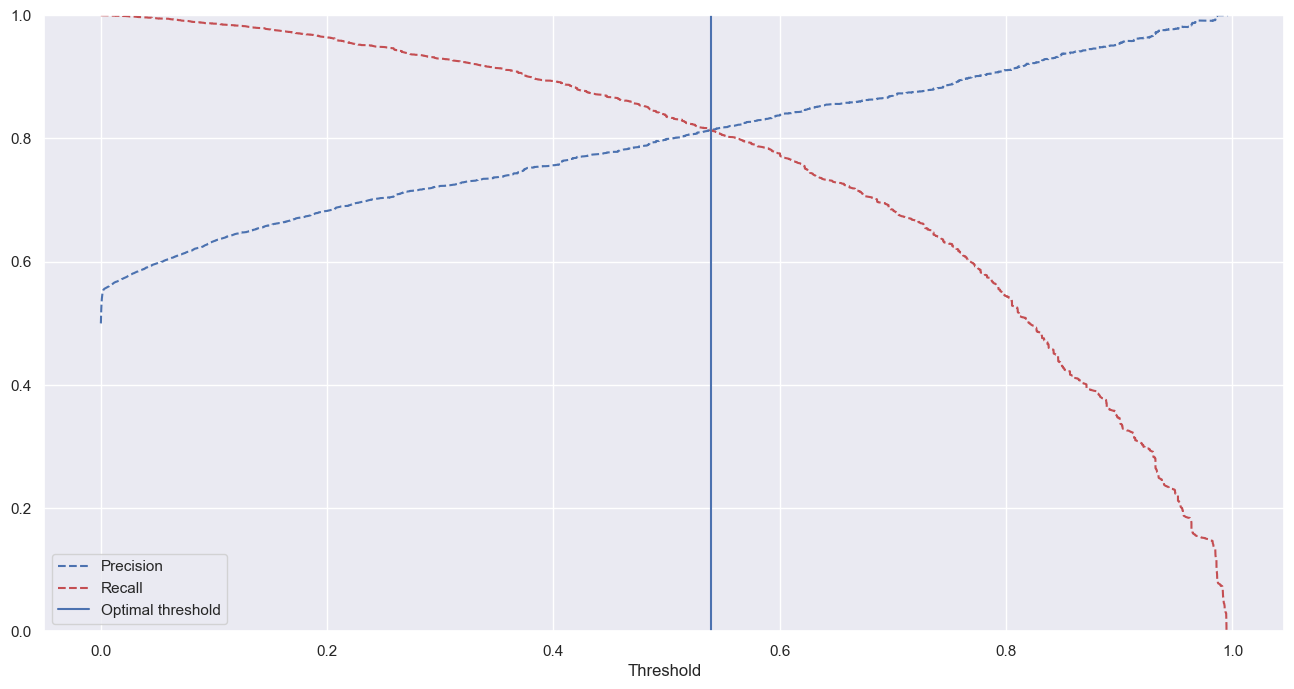

In [42]:
plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.axvline(x = optimal_proba_cutoff, color = 'b', label = 'Optimal threshold')

plt.xlabel('Threshold')
plt.legend(loc='lower left')
plt.ylim([0,1])
plt.show()

In [43]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(round(accuracy_score(y_test, y_pred), 4), round(accuracy_score(y_test, roc_predictions), 4)))
print("Precision Score Before and After Thresholding: {}, {}".format(round(precision_score(y_test, y_pred), 4), round(precision_score(y_test, roc_predictions), 4)))
print("Recall Score Before and After Thresholding: {}, {}".format(round(recall_score(y_test, y_pred), 4), round(recall_score(y_test, roc_predictions), 4)))
print("F1 Score Before and After Thresholding: {}, {}".format(round(f1_score(y_test, y_pred), 4), round(f1_score(y_test, roc_predictions), 4)))

Accuracy Score Before and After Thresholding: 0.8126, 0.8139
Precision Score Before and After Thresholding: 0.7992, 0.8138
Recall Score Before and After Thresholding: 0.8347, 0.8138
F1 Score Before and After Thresholding: 0.8166, 0.8138


Obtaining optimal probability thresholds using the PR curves is one way of maximizing the predictive capability.  We probability thresholds manually with the aim of maximizing either precision or recall, which depends on the problem you are trying to solve.

- **Minimize number of false positives**, i.e. maximize precision: If that algorithm only predicts that one user will churn (for instance if the user is completely inactive for months), it will have perfect precision. But clearly, this will mean that a lot of users who end up churning will not be identified, and you’ll have very low recall – not very useful.


- **Minimize number of false negatives**, i.e. maximize recall: if an algorithm predicts that every single user will churn, it would have perfect recall. But clearly, not every user will churn from your business – and your algorithm’s precision would end up being very low, and it wouldn’t be useful for your business.

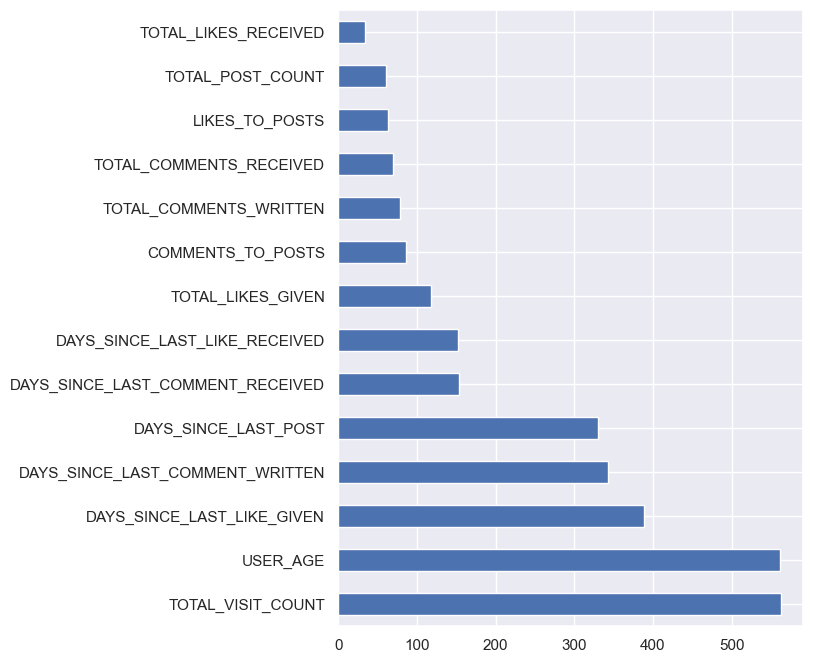

In [44]:
feat_imp = pd.Series(clf.feature_importances_, index=x.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(6,8))
plt.show()

In [45]:
feat_imp

TOTAL_VISIT_COUNT                   563
TOTAL_POST_COUNT                     60
TOTAL_LIKES_RECEIVED                 34
TOTAL_COMMENTS_RECEIVED              70
TOTAL_LIKES_GIVEN                   118
TOTAL_COMMENTS_WRITTEN               78
USER_AGE                            562
DAYS_SINCE_LAST_POST                330
DAYS_SINCE_LAST_LIKE_RECEIVED       152
DAYS_SINCE_LAST_LIKE_GIVEN          388
DAYS_SINCE_LAST_COMMENT_RECEIVED    153
DAYS_SINCE_LAST_COMMENT_WRITTEN     343
LIKES_TO_POSTS                       63
COMMENTS_TO_POSTS                    86
dtype: int32

In [46]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

In [47]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

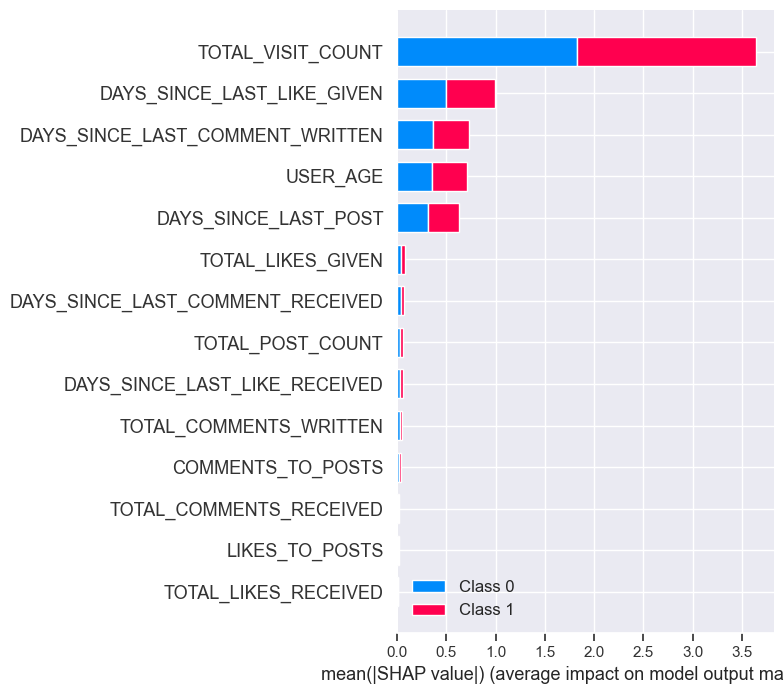

In [48]:
shap.summary_plot(shap_values, X_train)

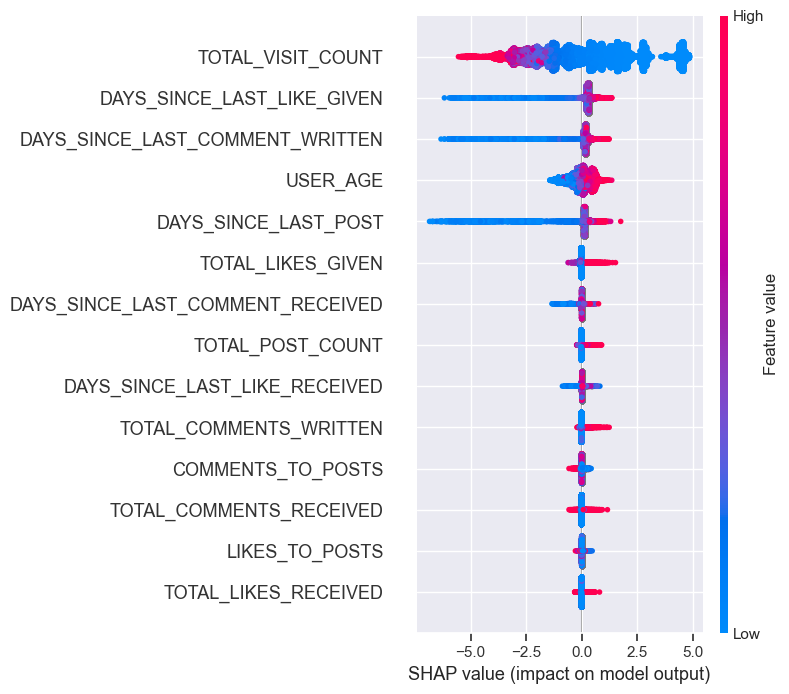

In [49]:
shap.summary_plot(shap_values[1], X_train)

Based on the feature importance output, we can determine which factors contribute the most to user churn. 
Strategies for user retention can be formulated based on these insights. 

To tackle this, we could:

##### **Encourage more frequent visits** 

The platform could introduce new features or initiatives that encourage users to visit more frequently, such as daily challenges, interesting daily content, or rewards for consistent daily logins.

Implement a feature like daily challenges or rewards for consistent daily logins for a certain percentage of users (let's say 10% - this group is often referred to as the treatment group). Compare their engagement metrics (like number of visits, time spent on the platform, and churn rate) with the rest of the users (the control group). If the treatment group shows significantly improved engagement and lower churn, it indicates the strategy is effective.

##### **Stimulate content creation** 

The platform could encourage users to create posts more regularly. This could be achieved by providing easy-to-use content creation tools, suggesting content ideas, or offering rewards for regular posting.

Similarly, you could provide enhanced content creation tools or content ideas to a subset of users and compare their content creation activity and churn rate with the control group. Increased content creation and reduced churn would indicate a successful strategy.

##### **Provide personalized content** 

The platform could enhance its content recommendation system to provide  users with more personalized and relevant content, increasing the likelihood of frequent visits and engagement.

Implement an enhanced content recommendation system for a subset of users. Track metrics such as click-through rate, time spent on the platform, and churn rate. If the treatment group shows improved engagement and lower churn, the personalized content strategy may be considered effective.

##### **Push Notifications:** 

Regularly send engaging notifications to the users based on their previous interactions. This could include updates about their connections, interesting posts, or reminders to check out new content.

Again, choose a subset of users to receive these notifications. Compare their engagement metrics and churn rate with those of the control group. If the treatment group shows better engagement and lower churn, the push notifications could be contributing to those improvements.

#### Hyperparameter Tuning
We will pick the best model from our dataframe above and perform a gridsearch with optuna to find the best "settings" (hyperparameters) for the algorithms.

In [50]:
import optuna
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)

    cv_scores = []
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],
        )
        
        preds = model.predict_proba(X_test)

        cv_scores.append(log_loss(y_test, preds))

    return np.mean(np.array(cv_scores))

In [51]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, x, y)
study.optimize(func, n_trials=20)

[I 2023-08-07 11:19:11,789] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=11.54964104699282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.54964104699282
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_s

[I 2023-08-07 11:19:12,817] Trial 0 finished with value: 0.4587391940767538 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07965579098118072, 'num_leaves': 2520, 'max_depth': 8, 'min_data_in_leaf': 8300, 'lambda_l1': 10, 'lambda_l2': 75, 'min_gain_to_split': 11.54964104699282, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.4587391940767538.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.626965006252437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.626965006252437
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_lea

[I 2023-08-07 11:19:20,015] Trial 1 finished with value: 0.40085156927331206 and parameters: {'n_estimators': 10000, 'learning_rate': 0.032720141297836854, 'num_leaves': 660, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 45, 'lambda_l2': 0, 'min_gain_to_split': 4.626965006252437, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.40085156927331206.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=10.58952856464039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.58952856464039
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2023-08-07 11:19:20,755] Trial 2 finished with value: 0.4541570266522245 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13588117590504206, 'num_leaves': 80, 'max_depth': 4, 'min_data_in_leaf': 4300, 'lambda_l1': 65, 'lambda_l2': 25, 'min_gain_to_split': 10.58952856464039, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.40085156927331206.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=6.670344221195479, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.670344221195479
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_sam

[I 2023-08-07 11:19:21,042] Trial 3 finished with value: 0.6931471820599393 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20610873683760098, 'num_leaves': 1580, 'max_depth': 3, 'min_data_in_leaf': 3500, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 6.670344221195479, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.40085156927331206.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=5.44699397826173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.44699397826173
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2023-08-07 11:19:23,247] Trial 4 finished with value: 0.4114191366572961 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15571358229725069, 'num_leaves': 1600, 'max_depth': 12, 'min_data_in_leaf': 2900, 'lambda_l1': 70, 'lambda_l2': 70, 'min_gain_to_split': 5.44699397826173, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.40085156927331206.
[I 2023-08-07 11:19:23,277] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,316] Trial 6 pruned. Trial was pruned at iteration 21.
[I 2023-08-07 11:19:23,340] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,371] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,400] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,454] Trial 10 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=12.880414530316205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.880414530316205
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90


[I 2023-08-07 11:19:23,507] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,554] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,602] Trial 13 pruned. Trial was pruned at iteration 1.
[I 2023-08-07 11:19:23,652] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,700] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,748] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,795] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2023-08-07 11:19:23,923] Trial 18 pruned. Trial was pruned at iteration 111.
[I 2023-08-07 11:19:23,971] Trial 19 pruned. Trial was pruned at iteration 0.


In [52]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.40085
	Best params:
		n_estimators: 10000
		learning_rate: 0.032720141297836854
		num_leaves: 660
		max_depth: 9
		min_data_in_leaf: 800
		lambda_l1: 45
		lambda_l2: 0
		min_gain_to_split: 4.626965006252437
		bagging_fraction: 0.6000000000000001
		bagging_freq: 1
		feature_fraction: 0.5
